In [1]:
import numpy as np
import os
import pandas as pd
import h5py
import seaborn as sns
import polars as pl
import matplotlib.pyplot as plt
from toolbox.utils import set_random_seed
from toolbox.plt_utils import density_scatter

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [3]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# for TF To find gpu
os.environ["LD_LIBRARY_PATH"] = f"{os.environ['CONDA_PREFIX']}/lib:" + os.environ.get("LD_LIBRARY_PATH", "")

In [4]:
# set random seed for reproducibility
set_random_seed(seed=42)

2025-12-23 16:35:08.747747: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/valehvpa/miniconda3/envs/hist6/lib:/usr/local/cuda/lib64:/usr/local/cuda/lib64
2025-12-23 16:35:08.747776: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow not installed, skipping tf seeding.


/home/valehvpa/miniconda3/envs/hist6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


# A new hv2

Instead of associated with each atac peak the hgp that completley ecnompasses it, associate it with its nearest hgp.  

Code below is from 12_1_2025.ipynb.  

Also I just found out I was using the wrong peak set all along in all hisobpnet models! 

Ran /home/valehvpa/projects/scCisTrans/histobpnet/experiments/valeh/scripts/narrowPeaks_to_summits_modified.sh to generate summits bed file for the correct peak set (peaks.all_input_regions.ENCSR637XSC.bed.gz).

Also ran this manually first as bedtools closest needs files to be lexicographically sorted according to their webapge and chatgpt.Als

In [ ]:
# !sort -k1,1 -k2,2n /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical.sorted > \
# /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical.sorted.lexicographic

/bin/bash: /home/valehvpa/miniconda3/envs/hist6/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [14]:
base_dir = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble"

# read histone peaks (3-column BED assumed: chrom, start, end)
histone_bed = os.path.join(base_dir, "maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical.sorted.lexicographic")
histone_df = pl.read_csv(
   histone_bed,
    separator="\t",
    has_header=False,
    new_columns=["chrom", "chromStart", "chromEnd"],
).select(["chrom", "chromStart", "chromEnd"])
assert len(histone_df.unique()) == len(histone_df)
print(histone_df.unique().shape, histone_df.shape)

# read chromosome sizes
chr_sizes = "/large_storage/goodarzilab/valehvpa/refs/hg38/hg38.chrom.sizes"
chr_sz_df = pl.read_csv(chr_sizes, separator="\t", has_header=False, new_columns=["chrom", "chrom_size"])

# add chromosome sizes to histone_df
histone_df = histone_df.join(
    chr_sz_df, left_on="chrom", right_on="chrom", how="left",
)
assert histone_df["chrom_size"].is_null().sum() == 0

# add length column
histone_df = histone_df.with_columns((pl.col("chromEnd") - pl.col("chromStart")).alias("length"))

histone_df_pd = histone_df.to_pandas()

(45097, 3) (45097, 3)


In [29]:
def run_closest_for_window_reverse(window: int, base_dir_override = None, atac_bed = None):
    print("*** Running for window size: ", window)

    if base_dir_override is None:
        base_dir_override = base_dir

    # read atac peaks, keep only chrom, chromStart, chromEnd
    atac_df = pl.read_csv(
        atac_bed,
        separator="\t",
        has_header=False,
        new_columns=[
            "chrom", "chromStart", "chromEnd", "name", "score", "strand",
        ],
    ).select(["chrom", "chromStart", "chromEnd"])

    # select cols
    histone_df.select(["chrom", "chromStart", "chromEnd"]).write_csv(
        os.path.join(base_dir_override,"temp_B.bed"),
        separator="\t",
        include_header=False
    )
    atac_df.select(["chrom", "chromStart", "chromEnd"]).write_csv(
        os.path.join(base_dir_override,"temp_A.bed"),
        separator="\t",
        include_header=False
    )

    # https://bedtools.readthedocs.io/en/latest/content/tools/closest.html
    fn_prefix = f"reverse_gapped_peak_histone_closest_{str(window)}bp"
    # -t first returns the "first" closest feature in B in case of ties
    cmd = f"cd {base_dir_override} && \
        bedtools closest -a temp_A.bed -b temp_B.bed -t first > {fn_prefix}_atac.bed && \
        command rm -rf temp_A.bed && \
        command rm -rf temp_B.bed"
    os.system(cmd)

In [30]:
bdo = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data"
run_closest_for_window_reverse(
    2114,
    base_dir_override=bdo,
    atac_bed=os.path.join(bdo, "peaks.all_input_regions.ENCSR637XSC.summits.2114bp.sorted.lexicographic.bed.gz"),
)

*** Running for window size:  2114


In [31]:
!head /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data/reverse_gapped_peak_histone_closest_2114bp_atac.bed

/bin/bash: /home/valehvpa/miniconda3/envs/hist6/lib/libtinfo.so.6: no version information available (required by /bin/bash)
chr1	8995	11109	chr1	777901	780141
chr1	777346	779460	chr1	777901	780141
chr1	777610	779724	chr1	777901	780141
chr1	777755	779869	chr1	777901	780141
chr1	778062	780176	chr1	777901	780141
chr1	803509	805623	chr1	804218	805669
chr1	803857	805971	chr1	804218	805669
chr1	804457	806571	chr1	804218	805669
chr1	825985	828099	chr1	826510	828466
chr1	826264	828378	chr1	826510	828466


In [32]:
!wc -l /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data/reverse_gapped_peak_histone_closest_2114bp_atac.bed

/bin/bash: /home/valehvpa/miniconda3/envs/hist6/lib/libtinfo.so.6: no version information available (required by /bin/bash)
277907 /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data/reverse_gapped_peak_histone_closest_2114bp_atac.bed


In [33]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data/reverse_gapped_peak_histone_closest_2114bp_atac.bed"
df = pd.read_csv(p, sep="\t", header=None, names=["chrom_atac", "start_atac", "end_atac", "chrom_histone", "start_histone", "end_histone"])
df

,chrom_atac,start_atac,end_atac,chrom_histone,start_histone,end_histone
0,chr1,8995,11109,chr1,777901,780141
1,chr1,777346,779460,chr1,777901,780141
2,chr1,777610,779724,chr1,777901,780141
3,chr1,777755,779869,chr1,777901,780141
4,chr1,778062,780176,chr1,777901,780141
...,...,...,...,...,...,...
277902,chrX,156012422,156014536,chrX,155997182,155998268
277903,chrX,156012694,156014808,chrX,155997182,155998268
277904,chrX,156015787,156017901,chrX,155997182,155998268
277905,chrY,4990899,4993013,.,-1,-1


In [34]:
df[df["chrom_histone"] == "."]

,chrom_atac,start_atac,end_atac,chrom_histone,start_histone,end_histone
277905,chrY,4990899,4993013,.,-1,-1
277906,chrY,15354512,15356626,.,-1,-1


In [35]:
!wc -l /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data/reverse_gapped_peak_histone_closest_2114bp_atac.bed

/bin/bash: /home/valehvpa/miniconda3/envs/hist6/lib/libtinfo.so.6: no version information available (required by /bin/bash)
277907 /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data/reverse_gapped_peak_histone_closest_2114bp_atac.bed


DEbugging sokemthing..

In [ ]:
# regions_bed = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/gm12878_atac_encode/ENCFF971WEQ/peaks.all_input_regions.ENCSR637XSC.bed.gz"
# df = pd.read_csv(regions_bed, sep='\t', header=None)

# def read_chrom_sizes(fname):
#     with open(fname) as f:
#         gs = [x.strip().split('\t') for x in f]
#     gs = {x[0]: int(x[1]) for x in gs if len(x)==2}

#     return gs
# cs = "/large_storage/goodarzilab/valehvpa/refs/hg38/hg38.chrom.sizes"
# chrom_sizes = read_chrom_sizes(cs)

# df['is_peak'] = True

# if chrom_sizes is not None:
#     # assume column 0 is chr, column 9 is the summit, column 1 is start, column 2 is end
#     flank_length = 2114 // 2 + 0
#     chrom_lengths = df.iloc[:, 0].map(lambda chrom: int(chrom_sizes.get(chrom, float('inf'))))
#     assert (df.shape[1] >= 10), "DataFrame should have at least 10 columns after expanding to 10 columns."
#     center = (df.iloc[:, 9] + df.iloc[:, 1])
#     filtered_df = df[
#         (center - flank_length > 0) &
#         (center + flank_length <= chrom_lengths)
#     ]
# else:
#     filtered_df = df
# filtered_df.columns = ['chr', 'start', 'end', 'name', 'score', 'strand', 'signalValue', 'pValue', 'qValue', 'summit', 'is_peak']

# def center_region_around_summit(df, width):
#     df.loc[:, 'start'] = df.loc[:, 'start'].astype(np.int64) + df.loc[:, 'summit'] - width // 2
#     df.loc[:, 'end'] = df.loc[:, 'start'] + width 
#     df.loc[:, 'summit'] = width // 2
#     return df
# width = 2114
# filtered_df = center_region_around_summit(filtered_df, width)

# # Reset index to avoid index errors
# filtered_df = filtered_df.reset_index(drop=True)

# def add_peak_id(df, chr_key: str = "chr", start_key: str = "start", end_key: str = "end", inplace: bool = True):
#     if inplace:
#         df["peak_id"] = df[chr_key].astype(str) + ":" + df[start_key].astype(str) + "-" + df[end_key].astype(str)
#     else:
#         df_copy = df.copy()
#         df_copy["peak_id"] = df_copy[chr_key].astype(str) + ":" + df_copy[start_key].astype(str) + "-" + df_copy[end_key].astype(str)
#         return df_copy
# add_peak_id(filtered_df)

# #####

# peaks_df = filtered_df

# p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data/reverse_gapped_peak_histone_closest_2114bp_atac.bed"
# atac_hgp_df = pd.read_csv(p, sep="\t", header=None, names=[
#     "chrom", "start", "end", "hist_chrom", "hist_start", "hist_end"
# ])
# add_peak_id(atac_hgp_df, chr_key="chrom")

# #####

# merged = peaks_df.merge(
#     atac_hgp_df[["peak_id", "hist_chrom", "hist_start", "hist_end"]],
#     on="peak_id",
#     how="left"
# )

# Distribution of distances  

Distribution of distances end_atac - start_hgp --> actually instead of this I want to skip the atac peaks who are not within Xbp of the hgp (in the sense coded below). Adn for those I set hist_chrom to -1 so that in the code after setting skip_missing_hist these will be effectively skipped.

In [27]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data/reverse_gapped_peak_histone_closest_2114bp_atac.bed"
atac_hgp_df = pd.read_csv(p, sep="\t", header=None, names=[
    "chrom", "start", "end", "hist_chrom", "hist_start", "hist_end"
])

In [28]:
# if end is < hist_start - 1000, or start > hist_end + 1000, then set out_of_bounds to True
X = 2000
atac_hgp_df["out_of_bounds"] = (atac_hgp_df["end"] < atac_hgp_df["hist_start"] - X) | (atac_hgp_df["start"] > atac_hgp_df["hist_end"] + X)
# if hist_chrom is ".", then also set out_of_bounds to True
atac_hgp_df.loc[atac_hgp_df["hist_chrom"] == ".", "out_of_bounds"] = True
atac_hgp_df["out_of_bounds"].sum() * 100 / len(atac_hgp_df)

45.3288330268759

In [29]:
# if end is < hist_start - 1000, or start > hist_end + 1000, then set out_of_bounds to True
X = 1000
atac_hgp_df["out_of_bounds"] = (atac_hgp_df["end"] < atac_hgp_df["hist_start"] - X) | (atac_hgp_df["start"] > atac_hgp_df["hist_end"] + X)
# if hist_chrom is ".", then also set out_of_bounds to True
atac_hgp_df.loc[atac_hgp_df["hist_chrom"] == ".", "out_of_bounds"] = True
atac_hgp_df["out_of_bounds"].sum() * 100 / len(atac_hgp_df)

46.71023040081754

In [30]:
idx = atac_hgp_df["out_of_bounds"] == True
atac_hgp_df.loc[idx, "hist_chrom"] = "."
atac_hgp_df.loc[idx, "hist_start"] = "-1"
atac_hgp_df.loc[idx, "hist_end"] = "-1"
# set dtype to int
atac_hgp_df["hist_start"] = atac_hgp_df["hist_start"].astype(int)
atac_hgp_df["hist_end"] = atac_hgp_df["hist_end"].astype(int)
del atac_hgp_df["out_of_bounds"]

/tmp/ipykernel_335338/316362100.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  atac_hgp_df.loc[idx, "hist_start"] = "-1"
/tmp/ipykernel_335338/316362100.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  atac_hgp_df.loc[idx, "hist_end"] = "-1"


In [31]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data/reverse_gapped_peak_histone_closest_2114bp_atac_within_1k_bound.bed"
atac_hgp_df.to_csv(
    p,
    sep="\t",
    header=False,
    index=False
)

Debugging..

In [10]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data/reverse_gapped_peak_histone_closest_2114bp_atac_within_1k_bound.bed"
test = pd.read_csv(p, sep="\t", header=None, names=[
    "chrom", "start", "end", "hist_chrom", "hist_start", "hist_end"
])
# [2025-12-22 17:39:00] INFO     🔵  Setting up data... (logger.py:32)
# [2025-12-22 17:42:39] INFO     🔵  Error fetching values for region: (logger.py:32)
# [2025-12-22 17:42:39] INFO     🔵  chr                                chr10 (logger.py:32)
# [2025-12-22 17:42:39] INFO     🔵  start                          100005657 (logger.py:32)
# [2025-12-22 17:42:39] INFO     🔵  end                            100007771 (logger.py:32)
# [2025-12-22 17:42:39] INFO     🔵  name                         Peak_129135 (logger.py:32)
# [2025-12-22 17:42:39] INFO     🔵  score                                970 (logger.py:32)
# [2025-12-22 17:42:39] INFO     🔵  strand                                 . (logger.py:32)
# [2025-12-22 17:42:39] INFO     🔵  signalValue                      2.87048 (logger.py:32)
# [2025-12-22 17:42:39] INFO     🔵  pValue                          97.04913 (logger.py:32)
# [2025-12-22 17:42:39] INFO     🔵  qValue                          95.00385 (logger.py:32)
# [2025-12-22 17:42:39] INFO     🔵  summit                              1057 (logger.py:32)
# [2025-12-22 17:42:39] INFO     🔵  is_peak                             True (logger.py:32)
# [2025-12-22 17:42:39] INFO     🔵  peak_id        chr10:100005657-100007771 (logger.py:32)
# [2025-12-22 17:42:39] INFO     🔵  hist_chrom                         chr10 (logger.py:32)
# [2025-12-22 17:42:39] INFO     🔵  hist_start                   100005065.0 (logger.py:32)
# [2025-12-22 17:42:39] INFO     🔵  hist_end                     100010846.0 (logger.py:32)

# test[(test["chrom"] == "chr10") & (test["start"] == 100005657) & (test["end"] == 100007771)]["hist_start"]

test

,chrom,start,end,hist_chrom,hist_start,hist_end
0,chr1,8995,11109,.,-1,-1
1,chr1,777346,779460,chr1,777901,780141
2,chr1,777610,779724,chr1,777901,780141
3,chr1,777755,779869,chr1,777901,780141
4,chr1,778062,780176,chr1,777901,780141
...,...,...,...,...,...,...
277900,chrX,155996523,155998637,chrX,155997182,155998268
277901,chrX,156011646,156013760,.,-1,-1
277902,chrX,156012422,156014536,.,-1,-1
277903,chrX,156012694,156014808,.,-1,-1


In [59]:
# ueError: No matching ATAC-Histone mapping found for region: chrY:15354512-15356626 (logger.py:32)
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data/reverse_gapped_peak_histone_closest_2114bp_atac.bed"
atac_hgp_df = pd.read_csv(p, sep="\t", header=None, names=[
    "chrom", "start", "end", "hist_chrom", "hist_start", "hist_end"
])
atac_hgp_df[(atac_hgp_df["chrom"] == "chrY") & (atac_hgp_df["start"] == 15354512) & (atac_hgp_df["end"] == 15356626)]

,chrom,start,end,hist_chrom,hist_start,hist_end
277906,chrY,15354512,15356626,.,-1,-1


Plot distirubtion of distances after all

In [ ]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data/reverse_gapped_peak_histone_closest_2114bp_atac.bed"
atac_hgp_df = pd.read_csv(p, sep="\t", header=None, names=[
    "chrom", "start", "end", "hist_chrom", "hist_start", "hist_end"
])
atac_hgp_df = atac_hgp_df[atac_hgp_df["hist_chrom"] != "."]

def compute_distance(row):
    if (row["start"] <= row["hist_end"]) and (row["end"] >= row["hist_start"]):
        return 0
    else:
        # mid_atac = (row["start"] + row["end"]) // 2
        dist_start = abs(row["end"] - row["hist_start"])
        dist_end = abs(row["start"] - row["hist_end"])
        return min(dist_start, dist_end)
atac_hgp_df["dist"] = atac_hgp_df.apply(compute_distance, axis=1)

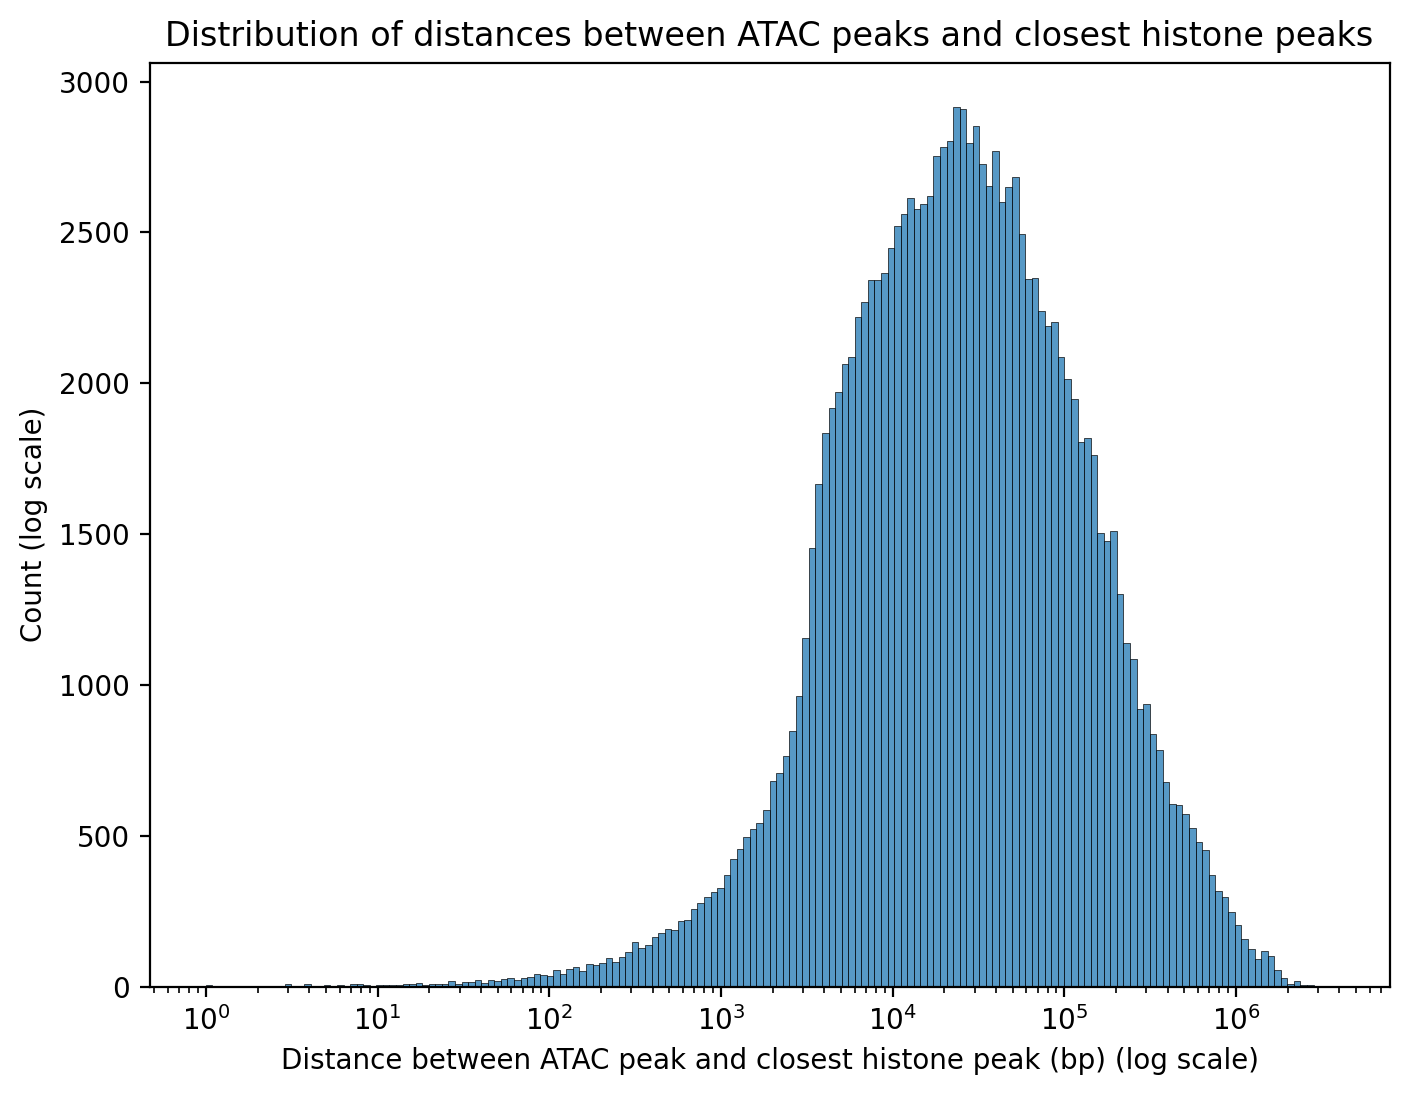

In [ ]:
# plot
non_zero_dist = atac_hgp_df[atac_hgp_df["dist"] > 0]["dist"]
plt.figure(figsize=(8,6))
sns.histplot(non_zero_dist, log_scale=(True, False))
plt.xlabel("Distance between ATAC peak and closest histone peak (bp) (log scale)")
plt.ylabel("Count (log scale)")
plt.title("Distribution of distances between ATAC peaks and closest histone peaks")
plt.show()

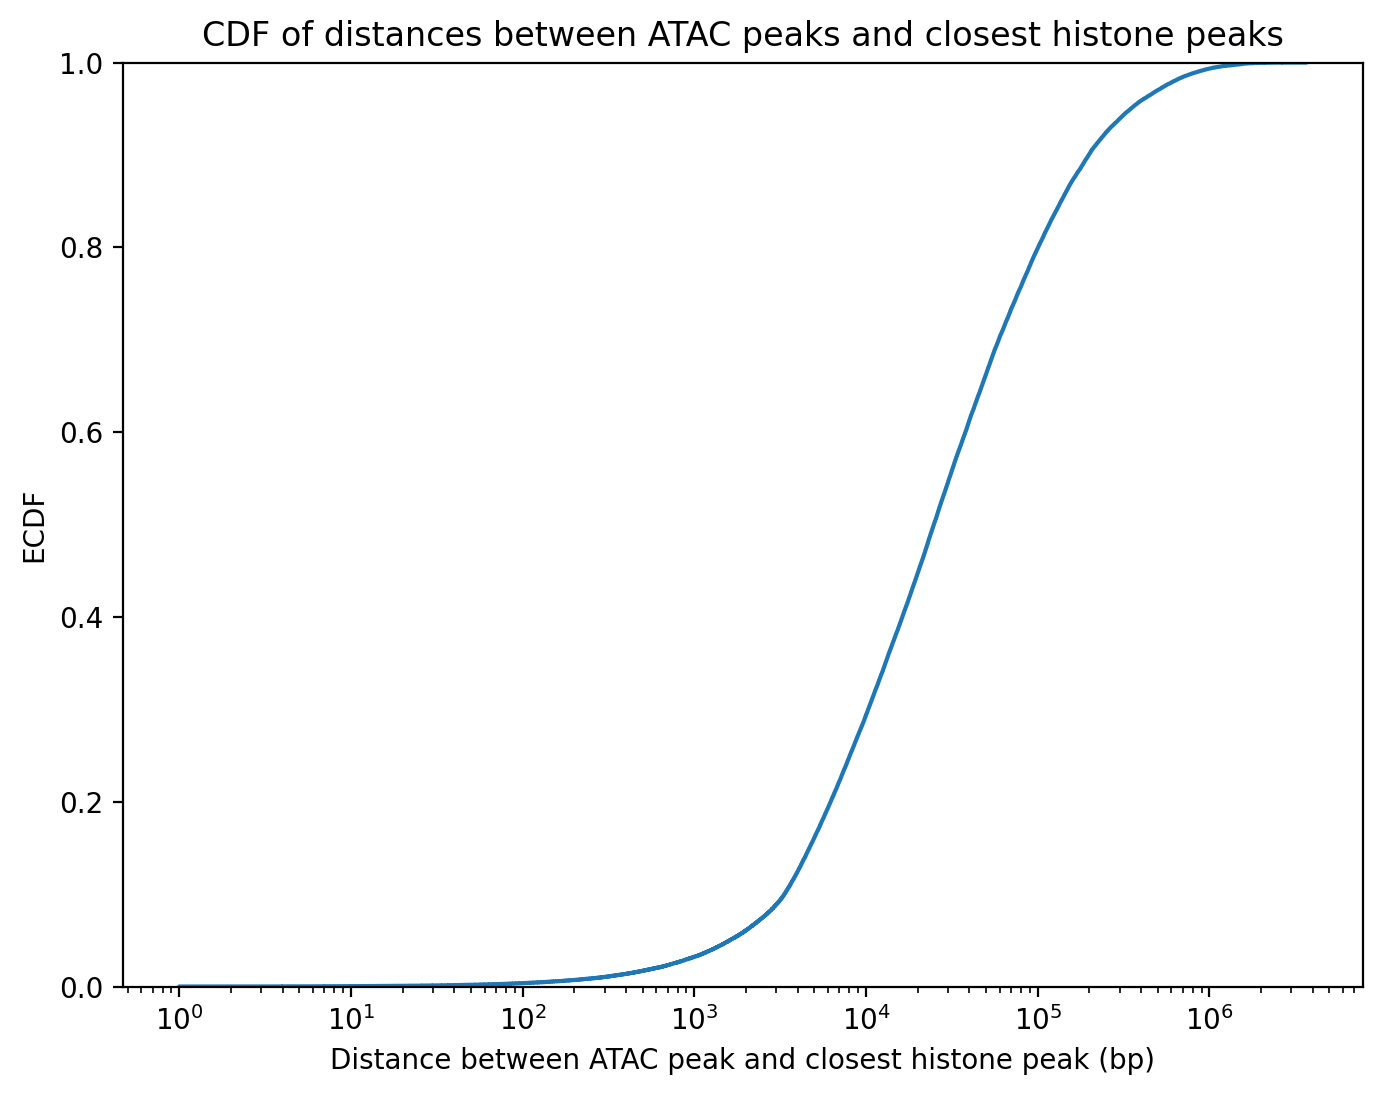

In [51]:
# plot cdf
plt.figure(figsize=(8,6))
sns.ecdfplot(non_zero_dist, log_scale=True)
plt.xlabel("Distance between ATAC peak and closest histone peak (bp)")
plt.ylabel("ECDF")
plt.title("CDF of distances between ATAC peaks and closest histone peaks")
plt.show()

NOTE: it looks like seaborn silently drops 0s if you pass log_Scale = True and have 0s in your series!

In [45]:
atac_hgp_df["dist"].describe()

count    2.779050e+05
mean     3.893642e+04
std      1.224922e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.307100e+04
max      3.683044e+06
Name: dist, dtype: float64

In [52]:
non_zero_dist.describe()

count    1.341220e+05
mean     8.067749e+04
std      1.664993e+05
min      1.000000e+00
25%      8.054000e+03
50%      2.484400e+04
75%      7.655325e+04
max      3.683044e+06
Name: dist, dtype: float64

Anyway so I guess the ccl is that for the atac peaks that dont overlap, their distances can be very large (75% of them are more than 8k away). biologically I think we expect that most atac peaks that regulate some hgp should either overlap with it or be very close to it (within 1-2kb). So I will set a threshold of 1kb and only keep those atac peaks that are within 1kb of some hgp (including those that overlap). For the rest I will set hist_chrom to -1 so that in the code after setting skip_missing_hist these will be effectively skipped.

# Why so many 0s in new hv2 post-encode-fix?

In [ ]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data/reverse_gapped_peak_histone_closest_2114bp_atac.bed"
atac_hgp_df = pd.read_csv(p, sep="\t", header=None, names=[
    "chrom", "start", "end", "hist_chrom", "hist_start", "hist_end"
])
atac_hgp_df

,chrom,start,end,hist_chrom,hist_start,hist_end
0,chr1,8995,11109,chr1,777901,780141
1,chr1,777346,779460,chr1,777901,780141
2,chr1,777610,779724,chr1,777901,780141
3,chr1,777755,779869,chr1,777901,780141
4,chr1,778062,780176,chr1,777901,780141
...,...,...,...,...,...,...
277902,chrX,156012422,156014536,chrX,155997182,155998268
277903,chrX,156012694,156014808,chrX,155997182,155998268
277904,chrX,156015787,156017901,chrX,155997182,155998268
277905,chrY,4990899,4993013,.,-1,-1


In [8]:
def get_cts(
    peaks_df,
    bw,
    width: int,
    get_total_cts: bool = False,
):
    vals = []

    for _, r in peaks_df.iterrows():
        # w = r['length'] if width is None else width
        if width is not None:
            assert width % 2 == 0
            # take window of length width around center
            center = (r['hist_start'] + r['hist_end']) // 2
            start = center - (width // 2)
            end = center + (width // 2)
        else:
            start = r['hist_start']
            end = r['hist_end']
        if r["hist_chrom"] == ".":
            print("Skipping invalid histone chrom for region:", r)
            continue
        if not get_total_cts:
            vals.append(
                np.nan_to_num(bw.values(r['hist_chrom'],
                                        start,
                                        end))
            )
        else:
            vals.append(np.array([
                np.nansum(bw.values(r['hist_chrom'],
                                    start,
                                    end))
            ]))

    return vals

chip = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/maya_coverage/all_reps.bw"
# inputc = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/maya_coverage/inputc/inputc.bw"
import pyBigWig
chip_bw = pyBigWig.open(chip)
# inputc_bw = pyBigWig.open(inputc)
    
chip_cts = get_cts(atac_hgp_df, chip_bw, width=None, get_total_cts=True)
# inputc_cts = get_cts(df2, inputc_bw, 1000, get_total_cts=True)

Skipping invalid histone chrom for region: chrom            chrY
start         4990899
end           4993013
hist_chrom          .
hist_start         -1
hist_end           -1
Name: 277905, dtype: object
Skipping invalid histone chrom for region: chrom             chrY
start         15354512
end           15356626
hist_chrom           .
hist_start          -1
hist_end            -1
Name: 277906, dtype: object


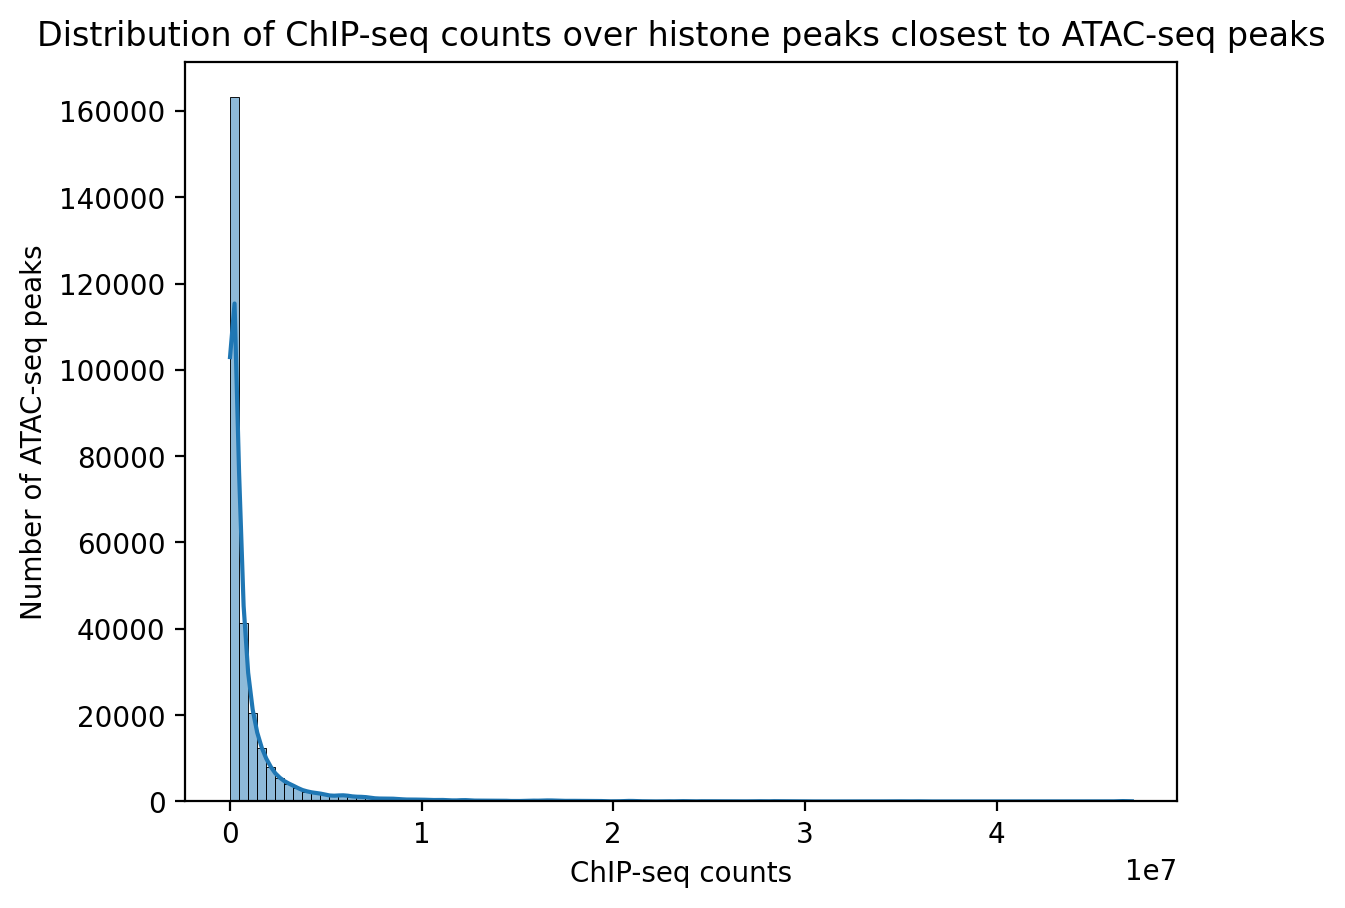

In [10]:
# plot distribution of chip_cts
chip_cts = [x[0] for x in chip_cts]  # flatten list of arrays
sns.histplot(chip_cts, bins=100, kde=True)
plt.title("Distribution of ChIP-seq counts over histone peaks closest to ATAC-seq peaks")
plt.xlabel("ChIP-seq counts")
plt.ylabel("Number of ATAC-seq peaks")
plt.show()

In [13]:
pd.Series(np.log1p(np.array(chip_cts))).describe()

count    277905.000000
mean         12.693305
std           1.618624
min           9.077609
25%          11.436422
50%          12.675986
75%          13.833342
max          17.666774
dtype: float64

Nvm the 0s I was seeijng was actually for hv3, not hv2...

# Is control correlated with length

In [5]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data/reverse_gapped_peak_histone_closest_2114bp_atac.bed"
atac_hgp_df = pd.read_csv(p, sep="\t", header=None, names=[
    "chrom", "start", "end", "hist_chrom", "hist_start", "hist_end"
])

In [6]:
atac_hgp_df

,chrom,start,end,hist_chrom,hist_start,hist_end
0,chr1,8995,11109,chr1,777901,780141
1,chr1,777346,779460,chr1,777901,780141
2,chr1,777610,779724,chr1,777901,780141
3,chr1,777755,779869,chr1,777901,780141
4,chr1,778062,780176,chr1,777901,780141
...,...,...,...,...,...,...
277902,chrX,156012422,156014536,chrX,155997182,155998268
277903,chrX,156012694,156014808,chrX,155997182,155998268
277904,chrX,156015787,156017901,chrX,155997182,155998268
277905,chrY,4990899,4993013,.,-1,-1


In [ ]:
def get_cts(
    peaks_df,
    bw,
    width: int,
    get_total_cts: bool = False,
):
    vals = []

    for _, r in peaks_df.iterrows():
        # w = r['length'] if width is None else width
        if width is not None:
            assert width % 2 == 0
            # take window of length width around center
            center = (r['hist_start'] + r['hist_end']) // 2
            start = center - (width // 2)
            end = center + (width // 2)
        else:
            start = r['hist_start']
            end = r['hist_end']
        if r["hist_chrom"] == ".":
            print("Skipping invalid histone chrom for region:", r)
            continue
        if not get_total_cts:
            vals.append(
                np.nan_to_num(bw.values(r['hist_chrom'],
                                        start,
                                        end))
            )
        else:
            vals.append(np.array([
                np.nansum(bw.values(r['hist_chrom'],
                                    start,
                                    end))
            ]))

    return vals

# chip = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/maya_coverage/all_reps.bw"
inputc = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/maya_coverage/inputc/inputc.bw"
import pyBigWig
# chip_bw = pyBigWig.open(chip)
inputc_bw = pyBigWig.open(inputc)
    
# chip_cts = get_cts(atac_hgp_df, chip_bw, width=None, get_total_cts=True)
inputc_cts = get_cts(atac_hgp_df, inputc_bw, width=None, get_total_cts=True)
inputc_cts = [x[0] for x in inputc_cts]  # flatten list of arrays

Skipping invalid histone chrom for region: chrom            chrY
start         4990899
end           4993013
hist_chrom          .
hist_start         -1
hist_end           -1
Name: 277905, dtype: object
Skipping invalid histone chrom for region: chrom             chrY
start         15354512
end           15356626
hist_chrom           .
hist_start          -1
hist_end            -1
Name: 277906, dtype: object


In [10]:
atac_hgp_df = atac_hgp_df[atac_hgp_df["hist_chrom"] != "."]

In [ ]:
atac_hgp_df["inputc_cts"] = inputc_cts
atac_hgp_df["hist_length"] = atac_hgp_df["hist_end"] - atac_hgp_df["hist_start"]

IndexError: invalid index to scalar variable.